# Formation energy prediction task 01

Подготовим прогноз энергии образования с помощью модели GNN. 

Let's prepare a prediction of the formation energy using the GNN model.

### Источники

- Материалы курса Сколтех по машинному обучению (Кирилл Сиднов):  
  [Каталог курса](https://new.skoltech.ru/en/course-catalog/?filter_id=SCatalogTab&section_id=SCatalogTab1&filters_by_category=intr_Kirill%20Sidnov&tabs=tab5)

- Силлабус курса (PDF):  
  [Syllabus of “Machine Learning” course by Kirill Sidnov, Skoltech, Spring 2024](https://files.skoltech.ru/data/edu/syllabuses/2024/I30202447.pdf?b4423)

## Import libraries Импорт библиотек

In [ ]:
# common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns
from datetime import date

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

# torch libraries
import torch
from torch.utils.data import DataLoader

# Torch geometric libraries
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as DataLoader_geometric

# import modules
from models.GNN_first import GCN

# assistive libraries
plt.rcParams.update(plt.rcParamsDefault) # Сброс настроек
import openpyxl # работа с excel

import pickle # модуль для сохранения обученных моделей

## Loading dataset Загружаем данные

In [2]:
# загружаем датафрейм df_Fm-3m.xlsx
PATH_FOR_LOAD = r'.\data\datafraims\df_Fm-3m.xlsx'
df_load = pd.read_excel(PATH_FOR_LOAD)

In [3]:
# смотрим
df_load.tail(2)

,composition,structure,formation_energy_per_atom
1255,Zr1 Sn3,Full Formula (Zr1 Sn3)\nReduced Formula: ZrSn3...,0.115889
1256,Zr1 Zn1,Full Formula (Zr1 Zn1)\nReduced Formula: ZrZn\...,0.104294


In [4]:
# создадим класс для загрузки графов из соответствующей папки репозитория  
class ProcessedDataset_new_dir(Dataset): # (наследник torch_geometric.data.Dataset)
    '''пользовательский класс ProcessedDataset для работы с предобработанными графами кристаллических структур, 
    сохраненными в файлах .pt, и выводит статистику о данных.'''

    # Инициализирует датасет:
    # root: Путь к папке с данными, transform/pre_transform/pre_filter: Опциональные функции для преобразования данных (не используются здесь).
    def __init__(self, root, new_dir_for_load_grahs, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.processed_new_dir = new_dir_for_load_grahs

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.processed_new_dir)  # Кастомный путь
    
    # Возвращает список файлов .pt в папке processed
    @property
    def processed_file_names(self):
        file_names = []
        for i in os.listdir(self.processed_dir):
            if '.pt' in i:
                file_names.append(i)
        return file_names
    

    # Возвращает количество графов в датасете:
    def len(self):
        return len(self.processed_file_names)

    # Загружает граф по индексу idx
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [5]:
# загружаем датасет
dataset = ProcessedDataset_new_dir('./', './data/graphs_structures_Fm_3m')

### Смотрим структуру загруженных графов

In [6]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


In [7]:
type(dataset), type(dataset[0]), type(dataset[0].x)
# type(dataset[0][0])

(__main__.ProcessedDataset_new_dir,
 torch_geometric.data.data.Data,
 torch.Tensor)

In [8]:
data_example = dataset[0]  # Get the first graph object.
print('type data_example', type(data_example))

print()
print('data_example', data_example)
print('=' * 79)

# Gather some statistics about the first graph.
print(f'Number of nodes: {data_example.num_nodes}')
print(f'Number of node features: {data_example.num_node_features}')
print(f'Number of edges: {data_example.num_edges}')
print(f'Number of edge feats: {data_example.num_edge_features}')

type data_example <class 'torch_geometric.data.data.Data'>

data_example Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Number of nodes: 32
Number of node features: 5
Number of edges: 192
Number of edge feats: 0


In [9]:
data_example.x

tensor([[89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 

In [10]:
data_example.y

tensor([[-4.4633]])

In [11]:
data_example.pos

tensor([[4.4906e+00, 4.4906e+00, 4.4906e+00],
        [7.4844e+00, 7.4844e+00, 4.4906e+00],
        [7.4844e+00, 4.4906e+00, 7.4844e+00],
        [1.0478e+01, 7.4844e+00, 7.4844e+00],
        [4.4906e+00, 7.4844e+00, 7.4844e+00],
        [7.4844e+00, 1.0478e+01, 7.4844e+00],
        [7.4844e+00, 7.4844e+00, 1.0478e+01],
        [1.0478e+01, 1.0478e+01, 1.0478e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9937e+00, 2.9937e+00, 9.4855e-17],
        [2.9937e+00, 9.4855e-17, 2.9937e+00],
        [5.9875e+00, 2.9937e+00, 2.9937e+00],
        [9.4855e-17, 2.9937e+00, 2.9937e+00],
        [2.9937e+00, 5.9875e+00, 2.9937e+00],
        [2.9937e+00, 2.9937e+00, 5.9875e+00],
        [5.9875e+00, 5.9875e+00, 5.9875e+00],
        [2.9937e+00, 2.9937e+00, 2.9937e+00],
        [5.9875e+00, 5.9875e+00, 2.9937e+00],
        [5.9875e+00, 2.9937e+00, 5.9875e+00],
        [8.9812e+00, 5.9875e+00, 5.9875e+00],
        [2.9937e+00, 5.9875e+00, 5.9875e+00],
        [5.9875e+00, 8.9812e+00, 5

In [12]:
data_example.lattice

tensor([[0.0000, 5.9875, 5.9875, 5.9875, 0.0000, 5.9875, 5.9875, 5.9875, 0.0000]])

In [13]:
# смотрим тип и как читается ссылка
type(dataset), dataset.processed_new_dir

(__main__.ProcessedDataset_new_dir, './data/graphs_structures_Fm_3m')

In [14]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


## Splitting the data into train and test  Разбивка данных на обучающие и тестовые

Для первого варианта возьмём размер обучающей выборки 85%

In [15]:
# 85% of data will be presented in the training set
train_fraction = 0.85

train_set_size = round(df_load.shape[0] * train_fraction)
print('Number of samples in the training set:', train_set_size)


# Get indexes for train and test # Получаем индексы обучающей и тестовой выборки

# Define train indices to compare differen models
train_idxs = df_load.sample(train_set_size).index

# Inverse selection of samples that are not in the train indices
test_idxs = df_load.loc[df_load.index.difference(train_idxs)].index

Number of samples in the training set: 1068


In [16]:
# получаем обучающий и тестовый датасеты
train_dataset = dataset[list(train_idxs)]
test_dataset = dataset[list(df_load.index.difference(train_idxs))]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1068
Number of test graphs: 189


## Breakdown of data by batches Разбивка данных по пакетам

In [17]:
# разбивка по пакетам
train_loader = DataLoader_geometric(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader_geometric(test_dataset, batch_size=228, shuffle=False)

# смотрим как разбились данные в train_loader
# we are looking at how the data is distributed in train_loader
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[10944, 5], y=[256, 1], pos=[10944, 3], lattice=[256, 9], edge_index=[2, 65664], batch=[10944], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[10200, 5], y=[256, 1], pos=[10200, 3], lattice=[256, 9], edge_index=[2, 61200], batch=[10200], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[9752, 5], y=[256, 1], pos=[9752, 3], lattice=[256, 9], edge_index=[2, 58512], batch=[9752], ptr=[257])

Step 4:
Number of graphs in the current batch: 256
DataBatch(x=[8992, 5], y=[256, 1], pos=[8992, 3], lattice=[256, 9], edge_index=[2, 53952], batch=[8992], ptr=[257])

Step 5:
Number of graphs in the current batch: 44
DataBatch(x=[1304, 5], y=[44, 1], pos=[1304, 3], lattice=[44, 9], edge_index=[2, 7824], batch=[1304], ptr=[45])



In [18]:
# смотрим как разбились данные в test_loader
# we are looking at how the data is distributed in test_loader
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 189
DataBatch(x=[6584, 5], y=[189, 1], pos=[6584, 3], lattice=[189, 9], edge_index=[2, 39504], batch=[6584], ptr=[190])



## Initiating the model / Инициируем модель

In [19]:
# # import modules
# from models.GNN_first import GCN

In [20]:
# defining hyperparameters / определяем гиперпараметры 
hyperparameters = {'hidden_embeding':128, 'num_node_features': dataset.num_node_features}

# инициируем модель 
model = GCN(hyperparameters=hyperparameters,)

## Optimizer and loss function / Оптимизатор и функция потерь

In [21]:
# создание оптимизатора Adam для обучения нейронной сети. Оптимизатор отвечает за обновление весов модели в процессе обучения.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# добавил самостоятельно, насколько это тут необходимо пока не совсем понимаю
criterion = torch.nn.MSELoss()

## Model launch function / Функция запуска модели

In [23]:
def run_model(model, epochs, train_loader, test_loader):
    """
    Основная функция для обучения и оценки модели.
    
    Параметры:
        model (torch.nn.Module): Нейронная сеть для обучения
        epochs (int): Количество эпох обучения
        train_loader (torch_geometric.loader.DataLoader): Загрузчик тренировочных данных
        test_loader (torch_geometric.loader.DataLoader): Загрузчик тестовых данных
    """
    
    def train():
        """
        Внутренняя функция для одной эпохи обучения.
        Возвращает суммарный лосс за эпоху.
        """
        # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
        model.train()
        val_loss = 0  # Инициализируем переменную для накопления лосса

        # Итерируемся по батчам тренировочных данных
        for data in train_loader:
            # 1. Прямой проход (forward pass) - вычисление предсказаний модели
            out = model(data)

            # 2. Вычисление функции потерь между предсказаниями и истинными значениями
            loss = criterion(out, data['y'])

            # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
            loss.backward()

            # 4. Обновление параметров модели на основе вычисленных градиентов
            optimizer.step()

            # 5. Обнуление градиентов перед следующим батчем
            optimizer.zero_grad()

            # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
            val_loss += loss.detach().item()

        return val_loss  # Возвращаем суммарный лосс за эпоху


    def test(loader):
        """
        Внутренняя функция для оценки модели на переданном загрузчике данных.
        Возвращает среднее значение R2-score по всем батчам.
        """
        # Переводим модель в режим оценки (отключаем Dropout и т.д.)
        model.eval()
        r2 = []  # Список для хранения R2-score по каждому батчу

        # Итерируемся по батчам данных (без вычисления градиентов)
        for data in loader:
            # Получаем предсказания модели
            out = model(data)

            # Преобразуем предсказания и истинные значения в 1D массивы
            pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
            true = data['y'].ravel()

            # Вычисляем R2-score для текущего батча и сохраняем
            r2.append(r2_score(pred.numpy(), true.numpy()))

        # Возвращаем среднее значение R2-score по всем батчам
        return np.array(r2).mean()

    # Основной цикл обучения
    for epoch in range(1, epochs+1):
        # Одна эпоха обучения и получение лосса
        val_loss = train()
        
        # Вывод информации о текущей эпохе
        print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

        # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
        if epoch % 10 == 0:
            train_acc = test(train_loader)  # R2 на тренировочных данных
            test_acc = test(test_loader)   # R2 на тестовых данных
            print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

 ## Launching training and testing of the model / Запуск обучения и тестирования модели

In [ ]:
# запускаем обучение и тестирование модели
run_model(model, 60, train_loader, test_loader)

Epoch: 001, Val Loss: 7.9595
Epoch: 002, Val Loss: 4.7652
Epoch: 003, Val Loss: 4.2678
Epoch: 004, Val Loss: 3.8051
Epoch: 005, Val Loss: 3.3100
Epoch: 006, Val Loss: 3.3478
Epoch: 007, Val Loss: 3.2302
Epoch: 008, Val Loss: 3.4298
Epoch: 009, Val Loss: 2.8721
Epoch: 010, Val Loss: 2.7114
Train R2: -0.2465, Test R2: -0.3866
Epoch: 011, Val Loss: 2.5901
Epoch: 012, Val Loss: 2.4946
Epoch: 013, Val Loss: 2.3693
Epoch: 014, Val Loss: 2.1639
Epoch: 015, Val Loss: 2.0564
Epoch: 016, Val Loss: 1.9482
Epoch: 017, Val Loss: 1.7922
Epoch: 018, Val Loss: 2.0046
Epoch: 019, Val Loss: 1.9043
Epoch: 020, Val Loss: 1.8024
Train R2: 0.4687, Test R2: 0.3352
Epoch: 021, Val Loss: 1.7031
Epoch: 022, Val Loss: 1.7811
Epoch: 023, Val Loss: 1.6925
Epoch: 024, Val Loss: 1.3539
Epoch: 025, Val Loss: 1.4758
Epoch: 026, Val Loss: 1.2528
Epoch: 027, Val Loss: 1.2568
Epoch: 028, Val Loss: 1.0993
Epoch: 029, Val Loss: 1.1226
Epoch: 030, Val Loss: 0.9930
Train R2: 0.7775, Test R2: 0.6794
Epoch: 031, Val Loss: 0.99

In [ ]:
# run_model(model, 60, train_loader, test_loader)

Epoch: 001, Val Loss: 9.0767
Epoch: 002, Val Loss: 4.8976
Epoch: 003, Val Loss: 3.8651
Epoch: 004, Val Loss: 3.6876
Epoch: 005, Val Loss: 3.4006
Epoch: 006, Val Loss: 3.3936
Epoch: 007, Val Loss: 3.0683
Epoch: 008, Val Loss: 2.9757
Epoch: 009, Val Loss: 2.7816
Epoch: 010, Val Loss: 2.9917
Train R2: 0.0522, Test R2: -0.2242
Epoch: 011, Val Loss: 2.5828
Epoch: 012, Val Loss: 2.3908
Epoch: 013, Val Loss: 2.4830
Epoch: 014, Val Loss: 2.4114
Epoch: 015, Val Loss: 2.3365
Epoch: 016, Val Loss: 2.0433
Epoch: 017, Val Loss: 2.0576
Epoch: 018, Val Loss: 2.0388
Epoch: 019, Val Loss: 1.6927
Epoch: 020, Val Loss: 1.6809
Train R2: 0.6358, Test R2: 0.4890
Epoch: 021, Val Loss: 1.5998
Epoch: 022, Val Loss: 1.6761
Epoch: 023, Val Loss: 1.5382
Epoch: 024, Val Loss: 1.3445
Epoch: 025, Val Loss: 1.3050
Epoch: 026, Val Loss: 1.3087
Epoch: 027, Val Loss: 1.4991
Epoch: 028, Val Loss: 1.8006
Epoch: 029, Val Loss: 1.8291
Epoch: 030, Val Loss: 1.4745
Train R2: 0.7044, Test R2: 0.5506
Epoch: 031, Val Loss: 1.291

## Сохраним обученную модель

Мы обучили модель, теперь нужно сохранить её именно в таком виде. Это нужно чтобы в дальнейшем получать предсказания без повторного обучения.

pickle — это модуль в Python, который позволяет сериализовать и десериализовать объекты, то есть сохранять объекты в файл и загружать их обратно. Сериализация (или "консервирование") — это процесс преобразования объекта в байтовый поток, который можно сохранить, а затем восстановить.

Почему pickle полезен в проектах машинного обучения:    
Сохранение моделей: После обучения модели машинного обучения ее можно сохранить с помощью pickle, чтобы не обучать заново каждый раз. Это экономит время, особенно для сложных моделей.     
Портативность: Сохраненную модель можно загрузить и использовать в другом скрипте или даже на другом устройстве.    
Сохранение промежуточных результатов: Кроме самой модели, можно сохранять промежуточные данные, такие как подготовленные признаки, предобработанные наборы данных или результаты кросс-валидации.

In [ ]:
# Coxpаняем модель с помощью piсkle
PATH_FOR_MODEL = 'models/pickle_models/GCN_model_2025_06_02.pkl'
with open(PATH_FOR_MODEL, 'wb') as f: # 'wb' указывает, что файл открыт для записи в бинарном режиме.
    pickle.dump(model, f)

In [38]:
# Загружаем сохранённую ранее модель с помощью piсkle
PATH_FOR_MODEL = 'models/pickle_models/GCN_model_2025_06_02.pkl'
with open(PATH_FOR_MODEL, 'rb') as f:
    model = pickle.load(f)

## Graph Model Evaluation / Оценка Графовой модели

In [39]:
model.eval() # переводим модель в режим тестирования

test_loader = DataLoader_geometric(test_dataset, batch_size=1)

pred, true = [], [] # инициируем списки для предсказанных и реальных значений прогнозируемой величины
for data in test_loader: # в цикле формируем данные списки
    out = model(data) # получение прогноза
    pred.append(out.item()) # заносим данные в список
    true.append(data.y.item()) # заносим данные в список

len(pred), len(true) # смотрим количество значений в списках

(189, 189)

In [40]:
# рассчёт метрик 
r2_score(pred, true), mean_absolute_error(pred, true)

(0.6824548823325753, 0.3422209849422822)

In [27]:
# введем вспомогательные переменные для оформления графика
r_2 = r2_score(pred, true)
mae_ = mean_absolute_error(pred, true)

test_targets_ = true
test_preds_ = pred

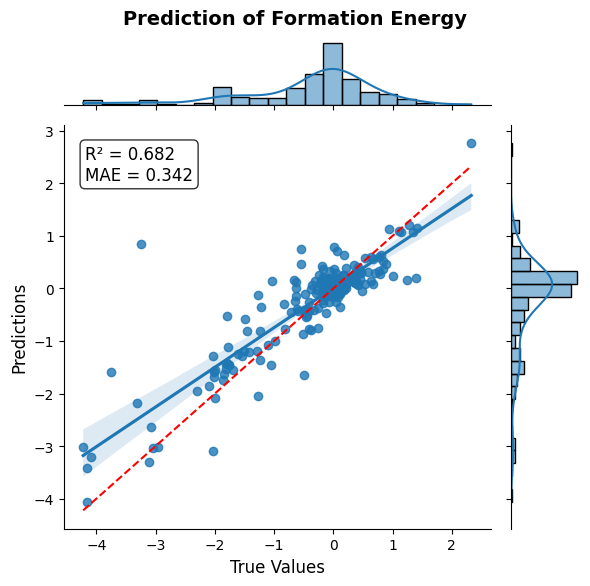

In [28]:
# оформим гарфик

g = sns.jointplot(x=test_targets_, y =test_preds_, kind='reg')

# Добавляем основной заголовок (в самый верх)
g.fig.suptitle('Prediction of Formation Energy', y=0.97, fontsize=14, fontweight='bold')
# Добавляем аннотации с метриками
text = f"R² = {r_2:.3f}\nMAE = {mae_:.3f}"
g.ax_joint.text(
    0.05, 0.95, #  координаты (5% от левого края, 95% от нижнего)
    text,
    transform=g.ax_joint.transAxes, # позиционирование относительно осей (0-1)
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8) # bbox создает полупрозрачный белый фон для лучшей читаемости
)

# Настройка осей
g.ax_joint.set_xlabel('True Values', fontsize=12)
g.ax_joint.set_ylabel('Predictions', fontsize=12)
g.ax_joint.plot([min(test_targets_), max(test_targets_)], 
                [min(test_targets_), max(test_targets_)], 
                'r--')  # Линия идеальных предсказаний
# plt.title('Prediction formation energy ')
plt.tight_layout() # предотвращает обрезание текста

plt.show()

## Saving the result to a table / Сохраним результат в таблицу

В таблице сохраним дату и время, название модели, прогнозируемая величина, название папки с данными, информация о %train, показатель r2, показатель MAE, комментарии.

In [ ]:
# # созданим датафрейм
# df_results = pd.DataFrame(columns=['Date', 'Model', 'Predicted_property', 'Name_data_folder', '%_train', 'Train_R2', 'Test_R2', 'Test_MAE', 'Comments'])

In [30]:
# загружаем датафрейм с историей результатов
PATH_FOR_SAVE = './results/df_results.xlsx'
df_results = pd.read_excel(PATH_FOR_SAVE)

In [31]:
df_results

,Date,Model,Predicted_property,Name_data_folder,%_train,Train_R2,Test_R2,Test_MAE,Comments
0,2025-04-02,from models.GNN_first import GCN,Formation_energy (eV/atom),data/graphs_structures_Fm_3m,15%,0.8216,0.6184,0.383903,First predict in this project


In [49]:
str(date.today())

'2025-04-02'

In [32]:
# добавляем данные в датафрейм
df_results.loc[len(df_results)] = \
    [str(date.today()),
     'from models.GNN_first import GCN',
     'Formation_energy (eV/atom)',
     'data/graphs_structures_Fm_3m',
     '15%',
     0.8123,
     0.6825,
     0.342,
     'New prediction'
     ]

In [33]:
# смотрим таблицу
df_results

,Date,Model,Predicted_property,Name_data_folder,%_train,Train_R2,Test_R2,Test_MAE,Comments
0,2025-04-02,from models.GNN_first import GCN,Formation_energy (eV/atom),data/graphs_structures_Fm_3m,15%,0.8216,0.6184,0.383903,First predict in this project
1,2025-06-02,from models.GNN_first import GCN,Formation_energy (eV/atom),data/graphs_structures_Fm_3m,15%,0.8123,0.6825,0.342000,New prediction


In [34]:
# записываем датафрейм
PATH_FOR_SAVE = './results/df_results.xlsx'
df_results.to_excel(PATH_FOR_SAVE, index=False)

## **Project results / Вывод по проекту: "Предсказание энергии образования кристаллов с помощью GCN"**  

### **Архитектура модели GCN для предсказания энергии образования кристаллов**

Применяемая модель представляет собой **графовую свёрточную нейронную сеть (GСN-Graph Convolutional Network)**, специально разработанную для анализа кристаллических структур. В данной работе модель применяется для предсказания их энергии образования. Она сочетает обработку локальных атомных взаимодействий и глобальных параметров кристаллической решётки. 

---

#### **1. Входные данные**  
Модель принимает на вход **графы кристаллических структур**, где:  
- **Узлы** — атомы с их свойствами (атомный номер, молярный объём, электроотрицательность и др.).  
- **Рёбра** — химические связи между атомами, заданные через `edge_index`.  
- **Глобальные параметры** — `lattice` тензор с параметрами кристаллической решётки - вектора трансляций (3×3 матрица в виде вектора из 9 элементов).  

---

#### **2. Основные компоненты архитектуры**

1. **Структурный эмбеддинг (PointTransformerConv)**  
   - Преобразует **атомные признаки** и их **геометрическое расположение** (координаты) в векторные представления.  
   - Учитывает связи между атомами (`edge_index`) и их пространственную близость (`pos`).  
   - Аналогичен механизму внимания (attention), но оптимизирован для материаловедческих задач.  

2. **Глобальное усреднение (Global Mean Pooling)**  
   - Агрегирует атомные эмбеддинги в **единый вектор** для всей кристаллической структуры.  
   - Позволяет модели работать с кристаллами разного размера.  

3. **Эмбеддинг решётки (Linear)**  
   - Кодирует **параметры кристаллической решётки** (периодичность ячейки) в скрытое пространство той же размерности, что и структурные признаки.  

4. **Объединение признаков**  
   - Вектор структурных признаков (после pooling) и вектор решётки объединяются в **один дескриптор кристалла**.  

5. **Полносвязные слои (MLP)**  
   - Каскад линейных слоёв с активацией ReLU:  
     - Уменьшает размерность объединённого вектора.  
     - Выявляет нелинейные зависимости между структурой и энергией.  

6. **Выходной слой (Linear)**  
   - Фиксирует результат в виде **скалярного значения** — предсказанной энергии образования.  

---

#### **3. Особенности архитектуры**  
- **Гибкость**: Может обрабатывать кристаллы с произвольным числом атомов благодаря механизму pooling.  
- **Учёт геометрии**: PointTransformerConv явно использует координаты атомов, что критично для материаловедения.  
- **Комбинация признаков**: Совмещает **локальные** (атомные) и **глобальные** (решёточные) свойства.  

---

#### **4. Ограничения и возможные улучшения**  
- **Нет учёта углов** между связями (можно добавить SchNet или DimeNet++).  
- **Отсутствие регуляризации** (например, Dropout) — может привести к переобучению на малых датасетах.  
- **Зависимость от качества графов**: Точность предсказаний сильно зависит от способа построения графа (например, выбора радиуса обрезания связей).  

---

#### **5. Практическое применение**  
Модель подходит для:  
- Быстрого скрининга стабильных кристаллических структур.  
- Предсказания свойств материалов без дорогостоящих квантово-химических расчётов.  
- Сравнительного анализа разных классов соединений (например, сплавов с одинаковой пространственной группой).  

Эта архитектура — **базовый, но эффективный инструмент** для задач материаловедения, который можно дорабатывать под конкретные требования.

### **Основные достижения**  
Проект успешно демонстрирует применение **графовых нейронных сетей (GNN)** для предсказания энергии образования кристаллических структур на данных из **Materials Project**. Ключевые результаты:  
- **Качество модели**:  
  - **Train R² = 0.8216**, **Test R² = 0.6184** — модель хорошо обучается, но есть риск переобучения (разница между train и test).  
  - Для улучшения можно добавить регуляризацию (Dropout, L2) или увеличить датасет.  
- **Архитектура**:  
  - Использован **PointTransformerConv** для учёта геометрии кристаллов + полносвязные слои.  
  - Учтены **параметры решётки** (lattice) — важный вклад в материаловедение.  

#### **Ограничения и пути улучшения**  
- **Данные**:  
  - Только структуры с **пространственной группой Fm-3m** (1257 образцов) — для более общих выводов нужны разнообразные данные.  
  - Нет проверки на мультикомпонентных системах (сплавы, оксиды).  
- **Модель**:  
  - Нет кросс-валидации — результаты могут быть нестабильными.  
  - Можно протестировать другие архитектуры (**CGCNN, MEGNet, ALIGNN**).  
- **Интерпретируемость**:  
  - Не анализируется, какие **атомные свойства** или **типы связей** влияют на энергию.  

#### **Практическая ценность**  
- **Для материаловедения**:  
  - Метод позволяет быстро предсказывать энергию образования без DFT-расчётов.  
  - Может использоваться для скрининга стабильных материалов.  
- **Для ML-инженеров**:  
  - Чёткий пайплайн: от данных до обучения GNN.  
  - Пример работы с **PyTorch Geometric** для кристаллов.  

#### **Рекомендации**  
1. **Расширить датасет**:  
   - Добавить другие пространственные группы и химические элементы.  
2. **Улучшить модель**:  
   - Добавить **BatchNorm** и **Dropout**.  
   - Протестировать **перекрёстную проверку**.  
3. **Визуализировать результаты**:  
   - Построить графики **зависимости ошибки от свойств кристаллов**.  
   - Использовать **GNNExplainer** для интерпретации.  

### **Итог**  
Проект служит **практическим руководством** по применению GNN в материаловедении. Для production-решения потребуется доработка, но текущая версия уже полезна для исследовательских целей.  

**Следующие возможные шаги**:  
- Добавить мультитаргетное предсказание (энергия + ширина зоны).  
- Реализовать **генерацию новых структур** с помощью GNN.

## Сравнение GNN-модели и классических ML-подходов в задачах предсказания свойств материалов

### Преимущества GNN-модели (PointTransformerGCN)

| Категория                                                          | Преимущество GNN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| ------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Учёт структуры**                                                 | GNN моделирует **атомную геометрию и связи**, чего нет у ML (где только векторы признаков).                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| **Обработка новых структур**                                       | GNN не требует заранее подготовленных дескрипторов (Пр: атомный радиус, электроотрицательность, плотность, объем ячейки, координационное число и т.д.) — достаточно структуры (графа).                                                                                                                                                                                                                                                                                                                                                    |
| **Поддержка CIF, .pt/.pkl  и других форматов**                     | Прямая работа с структурными данными из баз типа Materials Project.  GNN-модели могут работать напрямую с различными форматами структурных данных (например, CIF, POSCAR, JSON из Materials Project, а также предобработанные `.pt`/`.pkl` файлы). Это делает их гибкими в применении, особенно в проектах, где данные уже приведены к графовому виду. В нашем проекте, например, используются `.pt` файлы — уже подготовленные графы, без непосредственного чтения CIF.                                                                  |
| **Гибкость архитектуры**                                           | Легко дополняется под свои задачи (углы, внимание, мультитаргет). **GNN-модели в целом гибки** — можно добавлять модули для учёта углов (напр., DimeNet++), attention (GAT, PointTransformerConv) или делать мультитаргетное предсказание.  Применяемая в данной работе модель GCN использует внимание (attention) через PointTransformerConv.  Но модель сейчас не учитывает углы между связями и не реализует мультитаргет (по заданию прогнозируется только энергия образования). Учёт этих данных можно добавить в следующих работах. |
| **Модель учитывает физические данные о кристаллической структуре** | Модель использует `pos` позиции (координаты) атомов и `lattice` (решётка) - вектора трансляций, а также учёт связей `edge_index`  - определяет, **кто с кем связан**. Но в нашем  задании модель не учитывает **расстояния между атомами** — они могут храниться (например, в `edge_attr`), также не учитывается тип связи  одинарная, двойная и т.п.(edge\_features). Их можно добавить в дальнейшем.                                                                                                                                    |

### Недостатки GNN по сравнению с классическим ML

| Категория                | Ограничение GNN                                                               |
| ------------------------ | ----------------------------------------------------------------------------- |
| **Сложность реализации** | Требует понимания графов, PyG, работы с .pt/координатами                      |
| **Объём данных**         | Требует больше данных и более чувствительна к ошибкам в графах                |
| **Время обучения**       | Обучение медленнее и ресурсоёмкое (особенно с attention-слоями) и PointTransformerConv       |
| **Интерпретация**        | Сложно понять, что именно повлияло на предсказание без GNNExplainer |

### Что в итоге?

* Используем **GNN**, когда есть CIF/позиции/решётка, и нужен прогноз с учётом физики.
* Используем классические методы Machine Learning (**Random Forest/XGB)**, когда есть табличные признаки и нужна быстрая и простая модель.

GNN-модели, вроде используемой GCN PointTransformerGCN, существенно лучше обучаются на структурах и физических задачах, но выступают скорее в роли не замены, а дополнения к классической ML аналитике.
